In [5]:
main_dir = 'project_folder/'
func_dir = main_dir + 'utils/'
import sys
sys.path.insert(0,func_dir)

## Functions

### plotting functions

In [1]:

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.dimension import _Dimension, _PREFIXES_FACTORS, _LATEX_MU
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class TimeDimension(_Dimension):
    def __init__(self):
        super().__init__("s")
        for prefix, factor in _PREFIXES_FACTORS.items():
            latexrepr = None
            if prefix == "\u00b5" or prefix == "u":
                latexrepr = _LATEX_MU + "s"
            self.add_units(prefix + "s", factor, latexrepr)


def plot_correlations(df_, color, r_position, ax):
    """This function `plot_correlations` is used to create a scatter plot showing the 
    correlation between the 'actual' and 'predicted' values in a DataFrame `df_`. 
    Args:
        df_ (_type_): pandas dataframe containing the actual and predicted values
        color (_type_): scatter plot color
        r_position (_type_): where the correlation value will be plotted
        ax (_type_): object from fig, ax = plt.subplots()
    """
    sns.scatterplot(x='actual', data=df_,
                y='predicted', ax=ax,
                color=color, s=8, alpha=0.4)
    ax.tick_params(axis='both', labelsize=6, width=0.2, length=2.5, pad=1)
    ax.set_ylabel('predicted', fontsize=6, labelpad=1)
    ax.set_xlabel('neural activity', fontsize=6, labelpad=1)
    correlation = df_['actual'].corr(df_['predicted'])
    ax.text(x=r_position[0], y=r_position[1], s=f"r={correlation:.2f}", 
            fontsize=6, transform=ax.transAxes)
    ax.spines[:].set_linewidth(0.3)
    sns.despine()


import numpy as np
def plot_three_neurons(frame_start, frame_stop, resp, predictions, reordered_neurons, color, axes, animal='mouse', ylim=None, condition_type=None):
    """used to plot the responses of three neurons over a series of frames

    Args:
        frame_start (_type_): _description_
        frame_stop (_type_): _description_
        resp (_type_): _description_
        predictions (_type_): _description_
        reordered_neurons (_type_): _description_
        color (_type_): _description_
        axes (_type_): _description_
        animal (str, optional): _description_. Defaults to 'mouse'.
        ylim (_type_, optional): _description_. Defaults to None.
        condition_type (_type_, optional): _description_. Defaults to None.
    """
    if animal=='mouse':
        frame_indices = np.arange(frame_start, frame_stop)
    elif animal=='monkey':
        frame_indices = np.arange(16*frame_start, 16*frame_stop)
    n_frames = len(frame_indices)
    n_rows = len(axes)
    for neuron, ax in enumerate(axes.flat):
        ax.plot(frame_indices,resp[frame_indices,reordered_neurons[neuron]], 
                color=color, linewidth=0.6 )
        ax.plot(frame_indices,predictions[frame_indices,reordered_neurons[neuron]], 
                color='red', linewidth=0.6, alpha=0.8 )
        ax.set_ylim(ylim)
        if animal=='monkey':
            if condition_type =='SNR':
                ax.set_xticks(ticks=np.arange(16*frame_start, 16*frame_stop, 16*2), labels=np.arange(frame_start, frame_stop, 2))
                ax.set_ylim(top=ax.get_ylim()[1]+ (0.2*ax.get_ylim()[1]))
            elif condition_type =='SNR_spont':
                ax.set_xticks(np.arange(0,n_frames,24))
                ax.set_xticklabels(np.arange(1,31,3))
        else:
            ax.set_xticks(np.arange(frame_start+5, frame_stop,20))
            ax.set_xlim(frame_start-1, frame_stop+1)
        
        if neuron< n_rows-1:
            # print(neuron)
            ax.set_xticks([])
        else:
            ax.set_xlabel('image presentation no.', fontsize=6, labelpad=1)
        ax.spines[:].set_linewidth(0.3)
        ax.tick_params(axis='both', labelsize=6, width=0.2, length=2.5, pad=1)  
    sns.despine()
    plt.subplots_adjust(hspace=0.2)

In [101]:
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 

def make_mouse_df(mouse_stats_, dataset_types=['ori32','natimg32']):
    """This function `make_mouse_df` is creating a DataFrame from the provided 
    `mouse_stats_` data for different dataset types. It iterates over the dataset types, 
    extracts relevant information for each mouse and area, and then appends this information 
    to a list called `data`. Finally, it creates a DataFrame `df_mouse_all` from the 
    collected data and returns it.

    Args:
        mouse_stats_ (_type_): _description_
        dataset_types (list, optional): _description_. Defaults to ['ori32','natimg32'].

    Returns:
        _type_: _description_
    """
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r']
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                for split_half_r, snr, evar, null_evar in zip(split_half_rs, SNRs,values['evars'],values['evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area,
                        'EV': evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area,
                        'EV': null_evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 

def make_monkey_df(monkey_stats_, dataset_types=['SNR', 'RF_thin', 'RF_large']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif 'RS' in dataset_type:
            act_type = 'lights off'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                split_half_rs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['SNR_meanspont']
                for split_half_r, snr, evar, null_evar in zip(split_half_rs, SNRs,values['evars'],values['evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date':date,
                        'Area': area,
                        'EV': evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date': date,
                        'Area': area,
                        'EV': null_evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

## mouse predictions

In [3]:
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_evars_all_mice

mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)

get_evars_all_mice(main_dir, mouse_stats, activity_type='resp')
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont')
get_evars_all_mice(main_dir, mouse_stats, activity_type='resp', control_shuffle=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)


### plotting

In [102]:
df_mouse_all = make_mouse_df(mouse_stats)
df_mouse = df_mouse_all[df_mouse_all.control_shuffle==False]

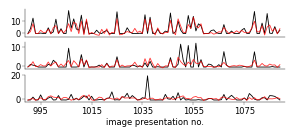

In [104]:
import numpy as np
from ridge_regression_functions import get_predictions_evars_parallel
import mouse_data_functions as cs

dataset_type = 'ori32'
mouse='ori32_M170717_MP033_2017-08-17'
area = 'L23'
mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity('resp', mouse)

snr = mouse_stats[dataset_type][mouse][area]['SNR_meanspont']
reli = mouse_stats[dataset_type][mouse][area]['split_half_r']
filtered_neurons_bool = (snr>=2)&(reli>=0.8)

evars_resp_mouse = mouse_stats[dataset_type][mouse][area]['evars'][filtered_neurons_bool]
sorted_indices = np.argsort(evars_resp_mouse)[::-1]
percentage = int(0.1 * len(evars_resp_mouse))
top_indices = sorted_indices[:percentage]
bottom_indices = sorted_indices[-percentage:]
median_ = df_mouse[(df_mouse['Activity Type']=='stimulus')&(df_mouse.Area=='L23')&(df_mouse['Split-half r']>0.8)&(df_mouse['SNR']>=2)]['EV'].median()
np.random.seed(17)
top10neuron = np.random.choice(top_indices)
np.random.seed(17)
bottom10neuron = np.random.choice(bottom_indices)
med_neuron = np.argwhere(np.isclose(evars_resp_mouse, median_, rtol=1e-03, atol=1e-03, equal_nan=False))[0][0]
evar_neurons_mouse = [top10neuron,med_neuron, bottom10neuron]


layer_to_predict = resp_L23[:,filtered_neurons_bool]
alpha = mouse_stats[dataset_type][mouse][area]['alpha']
sorted_y_preds, evars = get_predictions_evars_parallel(resp_L4, layer_to_predict, alpha=alpha, n_splits=10, frames_reduced=5)

n_rows = 3
n_columns = 1
fig, axes = plt.subplots(n_rows, n_columns, figsize=(3.35,1.2))
frame_start=990 
frame_stop =1090
plot_three_neurons(frame_start, frame_stop, layer_to_predict, sorted_y_preds, evar_neurons_mouse, 'black', axes, animal='mouse', ylim=None, condition_type=None)

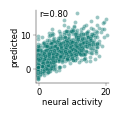

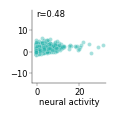

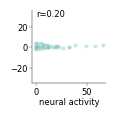

In [105]:
df_ = pd.DataFrame({'actual':layer_to_predict[:,top10neuron], 'predicted':sorted_y_preds[:,top10neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = '#007069'
plot_correlations(df_, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
plt.show()

df = pd.DataFrame({'actual':layer_to_predict[:,med_neuron], 'predicted':sorted_y_preds[:,med_neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = 'lightseagreen'
plot_correlations(df, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
ax.set(ylabel=None)
plt.show()

df = pd.DataFrame({'actual':layer_to_predict[:,bottom10neuron], 'predicted':sorted_y_preds[:,bottom10neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = '#73BFB7'
plot_correlations(df, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
ax.set(ylabel=None)
plt.show()



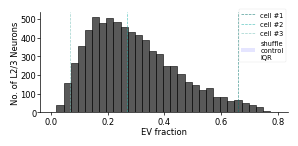

In [106]:
import scipy.stats as stats

med_evar = evars_resp_mouse[med_neuron]
top_evar = evars_resp_mouse[top10neuron]
bottom_evar = evars_resp_mouse[bottom10neuron]


fig, ax = plt.subplots(figsize=(3.2,1.3))
sns.histplot(df_mouse[(df_mouse['Activity Type']=='stimulus')&(df_mouse.Area=='L23')&(df_mouse['Split-half r']>0.8)&(df_mouse['SNR']>=2)]['EV'], color='#222222', ax=ax,
             linewidth=0.4, binwidth=0.025)

ax.axvline(top_evar, color='#007069', linestyle='--', linewidth=0.5, label='cell #1', alpha=0.7)
ax.axvline(med_evar, color='lightseagreen', linestyle='--', linewidth=0.5, label='cell #2', alpha=0.7)
ax.axvline(bottom_evar, color='#73BFB7', linestyle='--', linewidth=0.5, label='cell #3', alpha=0.7)


data = df_mouse_all[(df_mouse_all['Activity Type']=='stimulus')& (df_mouse_all.SNR > 2) & (df_mouse_all['Split-half r'] > 0.8) & (df_mouse_all.control_shuffle == True) & (df_mouse_all.Area == 'L23')]['EV']
per_25 = np.percentile(data.values, 25)
per_75 = np.percentile(data.values, 75)
ax.axvspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol\nIQR',
        linewidth=0,
           )

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel('No. of L2/3 Neurons', fontsize=6, labelpad=1)


# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
legend = ax.legend(loc=(0.8,0.5), fontsize=6*0.8)
legend.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

#### supplemental

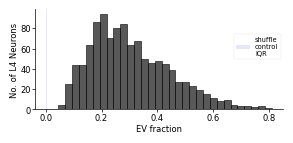

In [107]:
import scipy.stats as stats

med_evar = evars_resp_mouse[med_neuron]
top_evar = evars_resp_mouse[top10neuron]
bottom_evar = evars_resp_mouse[bottom10neuron]


fig, ax = plt.subplots(figsize=(3.2,1.3))
sns.histplot(df_mouse[(df_mouse['Activity Type']=='stimulus')&(df_mouse.Area=='L4')&(df_mouse['Split-half r']>0.8)&(df_mouse['SNR']>=2)]['EV'], color='#222222', ax=ax,
             linewidth=0.4, binwidth=0.025)

data = df_mouse_all[(df_mouse_all['Activity Type']=='stimulus')& (df_mouse_all.SNR > 2) & (df_mouse_all['Split-half r'] > 0.8) & (df_mouse_all.control_shuffle == True) & (df_mouse_all.Area == 'L4')]['EV']
per_25 = np.percentile(data.values, 25)
per_75 = np.percentile(data.values, 75)
ax.axvspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol\nIQR',
        linewidth=0,
           )

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel('No. of L4 Neurons', fontsize=6, labelpad=1)


# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
legend = ax.legend(loc=(0.8,0.5), fontsize=6*0.8)
legend.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

In [108]:
## 
df_mouse['Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_mouse['Split-half r'], df_mouse['SNR'])]
df_mouse['SNR > 2']=[True if y > 2 else False for _, y in zip(df_mouse['Split-half r'], df_mouse['SNR'])]
df_mouse['reliable']=[True if x > 0.8 else False for x, _ in zip(df_mouse['Split-half r'], df_mouse['SNR'])]
df_mouse.groupby(['Visually Responsive'])['EV'].agg('count')


/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_1365/2995299509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mouse['Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_mouse['Split-half r'], df_mouse['SNR'])]
/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_1365/2995299509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mouse['SNR > 2']=[True if y > 2 else False for _, y in zip(df_mouse['Split-half r'], df_mouse['SNR'])]
/var/folders/1q/qnh3vz

Visually Responsive
False    47311
True      8371
Name: EV, dtype: int64

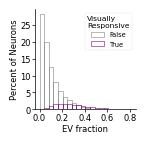

In [109]:
fig, ax = plt.subplots(figsize=(1.3,1.3))
sns.histplot(df_mouse, x='EV', fill=False, hue='Visually Responsive', color='#222222', ax=ax,hue_order=[True,False],
             linewidth=0.4, bins=20, palette=['purple', 'gray'], stat='percent')
ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel(f'Percent of Neurons', fontsize=6, labelpad=1)
# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)

ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()

ax.legend(alignment='center',title='Visually\nResponsive',title_fontsize= 6*0.9, labels=['False','True'],fontsize=6*0.8)
ax.legend_.get_frame().set_linewidth(0.2)
plt.show()

In [110]:
df_all = df_mouse.copy().reset_index()
df_all['cell type']='all'
df_snr = df_mouse[df_mouse['SNR > 2']==True].reset_index()
df_snr['cell type']='SNR > 2'
df_filt = df_mouse[df_mouse['Visually Responsive']==True].reset_index()
df_filt['cell type']='SNR > 2 &\nsplit-half r >0.8'
df_reli = df_mouse[df_mouse['reliable']==True].reset_index()
df_reli['cell type']='split-half r >0.8'
df_conditions_comparisons_mouse = pd.concat([df_all,df_reli,df_snr, df_filt]).reset_index()

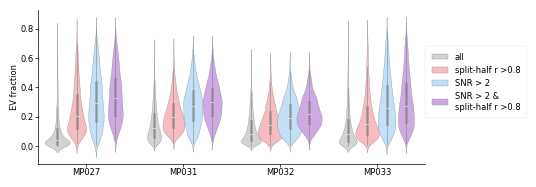

In [111]:
fig, ax = plt.subplots(figsize=(5,2))
sns.violinplot(df_conditions_comparisons_mouse,  y='EV', x='Mouse Name', hue='cell type', ax=ax,
               palette=['lightgray','#ffb3ba','#bae1ff','#d0a0ec'],
               inner_kws={'box_width':2, 'marker':'_', 'markersize':3,
                            'markeredgewidth':0.75,'alpha':0.5},gap=-.3,
             linewidth=0.2)
ax.set_xlabel(None)
ax.set_ylabel(f'EV fraction', fontsize=6, labelpad=1)

ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
ax.legend(alignment='center',
title_fontsize= 6, fontsize=6, loc= (1,0.3),
borderpad=0.75)
ax.legend_.get_frame().set_linewidth(0.2)
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

## macaque predictions

In [48]:
#depending on the dataset type, there are different times of autocorrelation to mitigate
all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
#different stimulus presentaion types have different durations
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 300, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':300, 
                      'RF_large_spont':300}

In [7]:
from neuron_properties_functions import  get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates, create_empty_monkey_stats_dict, get_evar_monkey_all_dates

monkey_stats=create_empty_monkey_stats_dict()
get_split_half_r_monkey_all_dates(monkey_stats)
get_SNR_monkey_all_dates(monkey_stats)

get_evar_monkey_all_dates(monkey_stats, control_shuffle=False)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)

### plotting

In [74]:
df_monkey_all = make_monkey_df(monkey_stats)
df_monkey = df_monkey_all[df_monkey_all.control_shuffle==False]

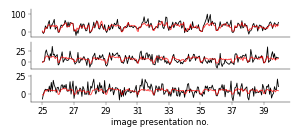

In [79]:
condition_type= 'SNR'
date = get_dates(condition_type)[1]
monkey_reli = monkey_stats[condition_type][date]['V4']['split_half_r']
v4_evars_resp=monkey_stats[condition_type][date]['V4']['evars'][monkey_reli > 0.8]
all_evars_monkey= df_monkey[(df_monkey['Area']=='V4')&(df_monkey['Split-half r']>0.8)&(df_monkey['SNR']>2)]['EV'].values

sorted_indices = np.argsort(all_evars_monkey)[::-1]
percentage = int(0.1 * len(all_evars_monkey))
top_threshold = all_evars_monkey[sorted_indices[percentage]]
bottom_threshold = all_evars_monkey[sorted_indices[-percentage]]
top_indices = np.argwhere(v4_evars_resp>top_threshold)[:,0]
bottom_indices = np.argwhere(v4_evars_resp<bottom_threshold)[:,0]
np.random.seed(17)
top10neuron= np.random.choice(top_indices)
np.random.seed(17)
bottom10neuron= np.random.choice(bottom_indices)

median_ = df_monkey[(df_monkey['Area']=='V4')&(df_monkey['Split-half r']>0.8)&(df_monkey['SNR']>2)]['EV'].median()
med_neuron = np.argwhere(np.isclose(v4_evars_resp, median_, rtol=1e-03, atol=1e-03, equal_nan=False))[0][0]
evar_neurons_monkey = [top10neuron,med_neuron, bottom10neuron]


from macaque_data_functions import get_resps
from ridge_regression_functions import get_predictions_evars_parallel
resp_V4, resp_V1 =get_resps(condition_type=condition_type, date=date, w_size=25, stim_on=0, stim_off=400)
layer_to_predict = resp_V4[:,monkey_reli > 0.8]
layer_to_use = resp_V1

alpha = monkey_stats[condition_type][date]['V4']['alpha']
sorted_y_preds,evars = get_predictions_evars_parallel(layer_to_use, layer_to_predict, alpha=alpha, 
                                                           n_splits=10, frames_reduced=5)
n_rows = 3
n_columns = 1
fig, axes = plt.subplots(n_rows, n_columns, figsize=(3.35,1.2))
frame_start=25
frame_stop =40
plot_three_neurons(frame_start, frame_stop, layer_to_predict, sorted_y_preds, evar_neurons_monkey, 'black', axes, animal='monkey', ylim=None, condition_type='SNR')
plt.show()

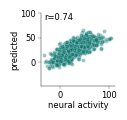

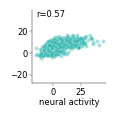

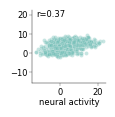

In [80]:
df_ = pd.DataFrame({'actual':layer_to_predict[:,top10neuron], 'predicted':sorted_y_preds[:,top10neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = '#007069'
plot_correlations(df_, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
plt.show()

df = pd.DataFrame({'actual':layer_to_predict[:,med_neuron], 'predicted':sorted_y_preds[:,med_neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = 'lightseagreen'
plot_correlations(df, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
ax.set_ylabel(None)
plt.show()

df = pd.DataFrame({'actual':layer_to_predict[:,bottom10neuron], 'predicted':sorted_y_preds[:,bottom10neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = '#73BFB7'
plot_correlations(df, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
ax.set_ylabel(None)
plt.show()

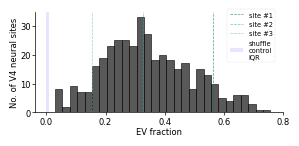

In [82]:
import scipy.stats as stats

med_evar = v4_evars_resp[med_neuron]
top_evar = v4_evars_resp[top10neuron]
bottom_evar = v4_evars_resp[bottom10neuron]


fig, ax = plt.subplots(figsize=(3.2,1.3))
sns.histplot(df_monkey[(df_monkey['Area']=='V4')&(df_monkey['Split-half r']>0.8)&(df_monkey['SNR']>2)]['EV'], 
             color='#222222', ax=ax, binwidth=0.025, linewidth=0.4)




ax.axvline(top_evar, color='#007069', linestyle='--', linewidth=0.5, label='site #1', alpha=0.7)
ax.axvline(med_evar, color='lightseagreen', linestyle='--', linewidth=0.5, label='site #2', alpha=0.7)
ax.axvline(bottom_evar, color='#73BFB7', linestyle='--', linewidth=0.5, label='site #3', alpha=0.7)


data = df_monkey_all[(df_monkey_all['Split-half r']>0.8)&(df_monkey_all['SNR']>2)&(df_monkey_all.control_shuffle==True)&(df_monkey_all.Area=='V4')]['EV']
per_25 = np.percentile(data.values, 25)
per_75 = np.percentile(data.values, 75)
ax.axvspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol\nIQR',
        linewidth=0,
           )

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel('No. of V4 neural sites', fontsize=6, labelpad=1)

# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
legend = ax.legend(loc=(0.775,0.5), fontsize=6*0.8)
legend.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

#### supplemental

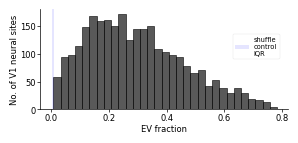

In [113]:
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(3.2,1.3))
sns.histplot(df_monkey[(df_monkey['Area']=='V1')&(df_monkey['Split-half r']>0.8)&(df_monkey['SNR']>2)]['EV'], 
             color='#222222', ax=ax, binwidth=0.025, linewidth=0.4)


data = df_monkey_all[(df_monkey_all['Split-half r']>0.8)&(df_monkey_all['SNR']>2)&(df_monkey_all.control_shuffle==True)&(df_monkey_all.Area=='V1')]['EV']
per_25 = np.percentile(data.values, 25)
per_75 = np.percentile(data.values, 75)
ax.axvspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol\nIQR',
        linewidth=0,
           )

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel('No. of V1 neural sites', fontsize=6, labelpad=1)

# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
legend = ax.legend(loc=(0.775,0.5), fontsize=6*0.8)
legend.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_1365/737375364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monkey['Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]


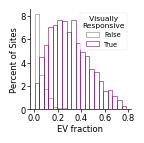

In [115]:
## 

df_monkey['Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]
fig, ax = plt.subplots(figsize=(1.3,1.3))
sns.histplot(df_monkey, x='EV', hue='Visually Responsive', fill=False, color='#222222', ax=ax,hue_order=[True,False],
             linewidth=0.4, bins=20, palette=['purple','gray'], stat='percent')
ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel(f'Percent of Sites', fontsize=6, labelpad=1)
# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
ax.legend(title = '   Visually\nResponsive',alignment='center',title_fontsize= 6*0.9, 
labels=['False','True'],fontsize=6*0.8)
ax.legend_.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

In [117]:
## 

df_monkey['Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]
df_monkey['SNR > 2']=[True if y > 2 else False for _, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]
df_monkey['reliable']=[True if x > 0.8 else False for x, _ in zip(df_monkey['Split-half r'], df_monkey['SNR'])]

/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_1365/3828157136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monkey['Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]
/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_1365/3828157136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monkey['SNR > 2']=[True if y > 2 else False for _, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]
/var/folders/1q/

In [118]:
df_all = df_monkey.copy().reset_index()
df_all['cell type']='all'
df_snr = df_monkey[df_monkey['SNR > 2']==True].reset_index()
df_snr['cell type']='SNR > 2'
df_filt = df_monkey[df_monkey['Visually Responsive']==True].reset_index()
df_filt['cell type']='SNR > 2 &\nsplit-half r >0.8'
df_reli = df_monkey[df_monkey['reliable']==True].reset_index()
df_reli['cell type']='split-half r >0.8'
df_conditions_comparisons_monkey = pd.concat([df_all,df_reli,df_snr, df_filt]).reset_index()

/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_1365/1845165151.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['monkey L'])


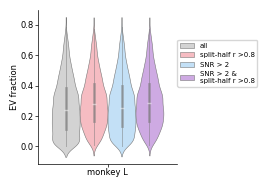

In [125]:
fig, ax = plt.subplots(figsize=(1.8,2))
sns.violinplot(df_conditions_comparisons_monkey,  y='EV', x='Activity Type', hue='cell type', ax=ax,
               palette=['lightgray','#ffb3ba','#bae1ff','#d0a0ec'],
               inner_kws={'box_width':2, 'marker':'_', 'markersize':3,
                            'markeredgewidth':1,'alpha':0.5},
             linewidth=0.4)
ax.set_xlabel(None)
ax.set_ylabel(f'EV fraction', fontsize=6, labelpad=1)
ax.set_xticklabels(['monkey L'])
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
ax.legend(loc=(1,0.5), fontsize=5)
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()